In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

# Read the data 

In [2]:
wine_data = load_wine()

wine_df = pd.DataFrame(
    data=wine_data.data,
    columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.sample(7)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
124,11.87,4.31,2.39,21.0,82.0,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380.0,1
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0,1
80,12.00,0.92,2.00,19.0,86.0,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278.0,1
162,12.85,3.27,2.58,22.0,106.0,1.65,0.60,0.60,0.96,5.58,0.87,2.11,570.0,2
12,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0
146,13.88,5.04,2.23,20.0,80.0,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415.0,2


In [3]:
wine_df['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [4]:
# All features without the target
n_features = wine_df.shape[1] - 1 

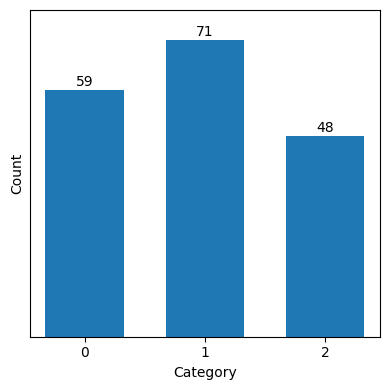

In [5]:
target_value_counts = wine_df['target'].value_counts().to_dict()
keys = list(target_value_counts.keys())
values = list(target_value_counts.values())

# Create the plot with a reduced figure size
fig, ax = plt.subplots(figsize=(4, 4))  

# Plot the bars with a reasonable width
ax.bar(keys, values, width=0.65)  
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks(keys)
ax.set_xticklabels(keys)

# Add text labels on top of the bars
for index, value in target_value_counts.items():
    plt.text(x=index, y=value+1, s=str(value), ha='center')

plt.ylim(0, max(values) * 1.1)

# Remove y-ticks
plt.yticks([])

plt.tight_layout()

## Train/test split 

In [6]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

# Baseline model: Decision Tree with all features 

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train classifier using all features
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9629629629629629


# Feature selection techniques
## Variance threshold

In [8]:
# Calculate the variance of each feature
X_train.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)

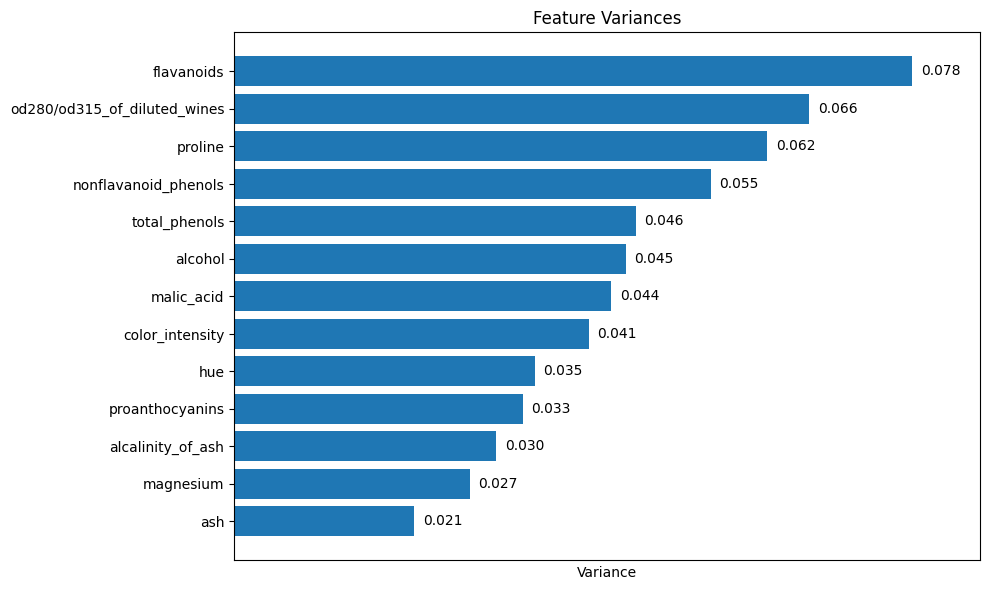

In [10]:
# Plot sorted variances
x = X.columns
y = scaled_X_train.var(axis=0)

# Sort the features and variance values
sorted_indices = np.argsort(y)[::-1]  # Sorting in descending order
sorted_x = x[sorted_indices]          # Sorted feature names
sorted_y = y[sorted_indices]          # Sorted variances

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_x, sorted_y)

# Add value labels next to the bars
for bar, value in zip(bars, sorted_y):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{value:.3f}', va='center')

# Adjust x-axis limit to prevent clipping
plt.xlim(0, max(sorted_y) * 1.1)

# Remove x-ticks
plt.xticks([])

# Set labels and title
plt.xlabel('Variance')
plt.title('Feature Variances')

# Invert y-axis to have the most variance at the top
plt.gca().invert_yaxis()

plt.tight_layout()


In [11]:
X_train_dropped = X_train.drop(['ash', 'magnesium'], axis=1)
X_test_dropped = X_test.drop(['ash', 'magnesium'], axis=1)

model.fit(X_train_dropped, y_train)

# Make predictions
preds = model.predict(X_test_dropped)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, preds)
print(accuracy)

1.0


## *k*-best features 

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

k_best_accuracy_list = []

for k in range(1, n_features+1):
    k_best_selector = SelectKBest(mutual_info_classif, k=k)
    k_best_selector.fit(X_train, y_train)
    
    sel_X_train = k_best_selector.transform(X_train)
    sel_X_test = k_best_selector.transform(X_test)
    
    model.fit(sel_X_train, y_train)
    k_best_preds = model.predict(sel_X_test)
    
    # Calculate accuracy 
    accuracy = accuracy_score(y_test, k_best_preds)
    k_best_accuracy_list.append(accuracy)

print([round(acc, 3) for acc in k_best_accuracy_list])

[0.796, 0.889, 0.963, 1.0, 1.0, 0.981, 0.981, 1.0, 0.981, 0.926, 1.0, 0.926, 0.963]


In [13]:
def plot_accuracies(accuracies_list):
    x = np.arange(1, len(accuracies_list)+1)
    y = [round(acc, 3) for acc in accuracies_list]

    _, ax = plt.subplots(figsize=(8, 6))

    # Create the vertical bar plot
    bars = ax.bar(x, y, width=0.4, color='lightblue')

    # Set x and y labels
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1.2)

    # Set custom ticks for x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, len(accuracies_list)+1))

    # Add value labels above the bars
    for bar, value in zip(bars, y):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, f'{value:.3f}', ha='center')

    plt.tight_layout()

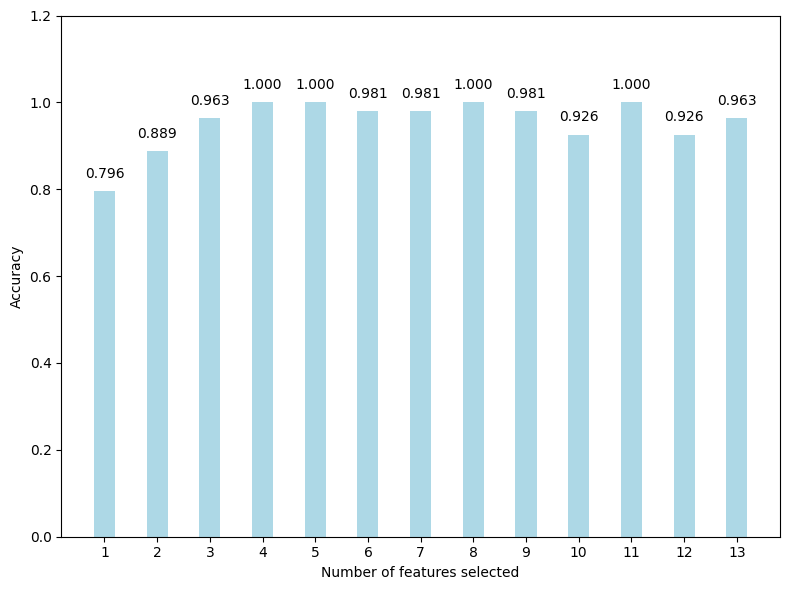

In [14]:
plot_accuracies(accuracies_list=k_best_accuracy_list)

In [15]:
def run_model_and_report(model, selector):
    model.fit(sel_X_train, y_train)
    preds = model.predict(sel_X_test)

    # Report selected featrures
    selected_feature_mask = selector.get_support()
    selected_features = X_train.columns[selected_feature_mask]
    print(f"Chosen features: {list(selected_features)}")

    # Calculate accuracy 
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy = {accuracy}")

In [16]:
# Model with the best number of features according to k_best_selector
k_best_selector = SelectKBest(mutual_info_classif, k=4)
k_best_selector.fit(X_train, y_train)
sel_X_train = k_best_selector.transform(X_train)
sel_X_test = k_best_selector.transform(X_test)

run_model_and_report(model=model,selector=k_best_selector)

Chosen features: ['flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']
Accuracy = 1.0


## Recursive feature elimination (RFE) 

In [17]:
from sklearn.feature_selection import RFE

rfe_accuracy_list = []

for k in range(1, n_features+1):
    RFE_selector = RFE(estimator=model, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train, y_train)
    
    sel_X_train = RFE_selector.transform(X_train)
    sel_X_test = RFE_selector.transform(X_test)
    
    model.fit(sel_X_train, y_train)
    RFE_preds = model.predict(sel_X_test)

    accuracy = model.score(sel_X_test, y_test)
    rfe_accuracy_list.append(accuracy)

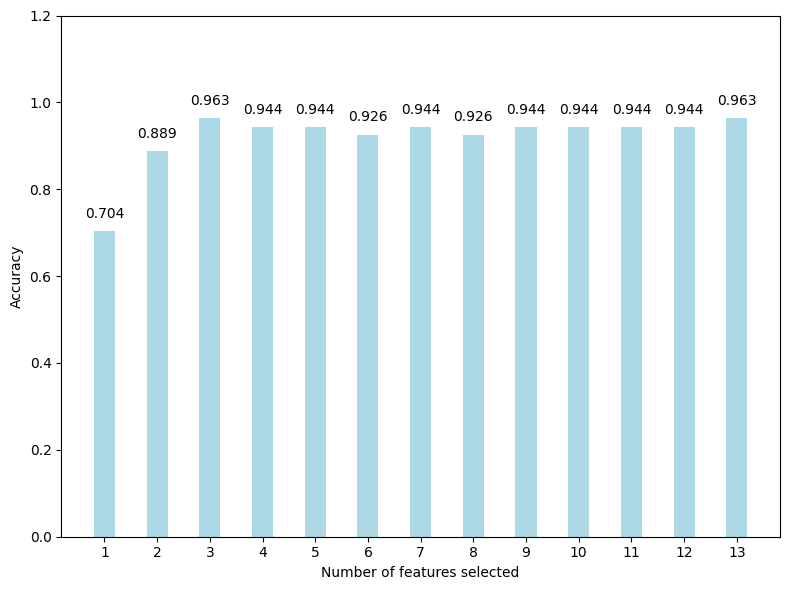

In [18]:
plot_accuracies(accuracies_list=rfe_accuracy_list)

In [19]:
# Model with the best number of features according to RFE_selector
RFE_selector = RFE(estimator=model, n_features_to_select=3, step=1)
RFE_selector.fit(X_train, y_train)
sel_X_train = RFE_selector.transform(X_train)
sel_X_test = RFE_selector.transform(X_test)

run_model_and_report(model=model,selector=RFE_selector)

Chosen features: ['flavanoids', 'color_intensity', 'proline']
Accuracy = 0.9629629629629629


# Sequential feature elimination / selection

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_accuracy_list = []

for k in range(1, 13):
    SFS_selector = SequentialFeatureSelector(model, n_features_to_select=k, direction='backward') # try direction='forward'
    SFS_selector.fit(X_train, y_train)
    
    sel_X_train = SFS_selector.transform(X_train)
    sel_X_test = SFS_selector.transform(X_test)
    
    model.fit(sel_X_train, y_train)
    RFE_preds = model.predict(sel_X_test)

    accuracy = model.score(sel_X_test, y_test)
    sfs_accuracy_list.append(accuracy)

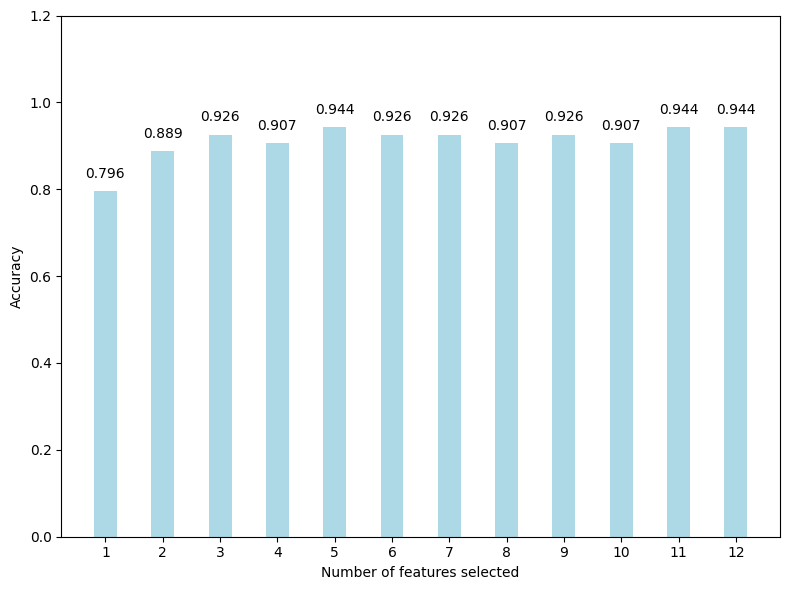

In [21]:
plot_accuracies(accuracies_list=sfs_accuracy_list)

In [22]:
# Model with the best number of features according to SFS_selector

SFS_selector = SequentialFeatureSelector(model, n_features_to_select=5, direction='backward') # try direction='forward'
SFS_selector.fit(X_train, y_train)
sel_X_train = SFS_selector.transform(X_train)
sel_X_test = SFS_selector.transform(X_test)

run_model_and_report(model=model,selector=SFS_selector)

Chosen features: ['alcohol', 'magnesium', 'flavanoids', 'nonflavanoid_phenols', 'hue']
Accuracy = 0.9444444444444444
